# Create and Run a Local RAG Pipeline from Scratch
## What is RAG
RAG is Retrieval Augmented Generation.
  
The goal or RAG is to take information and pass it to an LLM so it can generate output based on this information.

- Retrieval - Find relevant information given a query e.g., "What are the macronutrients and what do they do?" -> retrieves passages of text related to the macronutrients from a nutrition textbook.
- Augmented - We want to to take the relevant information that we got from retrieval, and augment our input (prompt) to an LLM with that relevant information.
- Generation - Take the first two steps and pass them to an LLM for generative outputs.

## Why RAG?
The main goal of RAG is to improve the generation outputs of LLMs.

1. Prevent Hallucinations - LLMS are incredibly good at generating good-looking text, however, this doesn't mean that the text is factual. RAG can help LLMs generate information based on relevant passages that are factual.
2. Work with custom data- Many LLMs are trained with internet scale data. This means they have a good understanding of language in general.
However, it also does mean that a lot of responses can be generic in nature. RAG helps to create specific responses to specific documents (e.g your own company's customer support documents).

If you want to read where RAG came from, read the paper from Facebook AI.
- https://arxiv.org/abs/2005.11401

Upstream Notebook for Lesson:
- https://github.com/mrdbourke/simple-local-rag/blob/main/00-simple-local-rag.ipyn

## What can RAG be used for?
- Customer support Q&A chat - Treat your customer support documents as a resource and when a customer asks a question, you could have a retrieval system, retrieve relevant documentation snippets, and then have an LLM craft those snippets into an answer. Think of this as a "chatbot for your documentation".
- Email chain analysis - Let's say you are a large insurance company and you have chains and chains of emails of customer claims. You could use a RAG pipeline to find relevant information from those emails, and then use an LLM to process that information into structured data.
- Company internal documentation chat.
- Texbook Q&A - Let's say you are a nutritions student, and you have a 1200 page textbook read, you could build a RAG pipeline to go through the textbook, and find relevant passages to the questions you have.

Common Theme Here: take your relevant documents to a query, and process them with an LLM.
  
From this angle, you can consider an LLM as a calculator for words.

## Why Local?
- Fun

Privacy, speed, cost

- Privacy - If you have private information, maybe you don't want to send that to an API. You want to set up an LLM and run that on your own hardware.
- Speed - Whenever you use an API, you have to send some kind of data across the internet. This takes time. Running locally means we don't have to wait for transfers of data.
- Cost - If you own your hardware, the cost is paid. It may have a large cost to begin with. But overtime, you don't have to keep paying API fees.
- No vendor lock-in - If you run your own software/hardware. If OpenAI or another large internet company shutdown, you can still run your business.

## What we're going to build
- https://github.com/mrdbourke/simple-local-rag
  
We're going to build NutriChat to "chat with a nutrition textbook".
  
Specifically:
1. Open a PDF document (we can use any PDF, or a collection).
2. Format the text of the PDF textbook ready for an embedding model.
3. Embed all the chunks of text in the textbook and turn them into numerical representations (embedding) which we can store for later.
4. Build a retrieval system that uses vector search to find relevant chunk of text based on a query.
5. Generate a prompt that incorporates the retreived pieces of text.
6. Generate an answer to a query based on the passages of text in the book with an LLM.
  
All Locally!
  
1. Step 1-3: Document preprocessing and embedding creation.
2. Step 4-6: Search and answer.

## 0. Prerequisites
We need atleast PyTorch v2.0

You might need to restart the notebook a couple times to get rid of errors related to 
1. PyTorch
2. spaCy
3. sentence_transformers.

In [1]:
import torch
torch.__version__

'2.2.2+cu118'

In [2]:
# For this notebook to run with updated APIs, we need torch 2.0+
try:
    import torch
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 2.0+"
    print(f"torch version: {torch.__version__}")
except:
    print(f"[INFO] torch version not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
    import torch
    print(f"torch version: {torch.__version__}")

torch version: 2.2.2+cu118


## 1. Document/Text Processing and Embedding Creation
Ingredients:
- PDF document of choice - This could be any document of choice, not necessarily PDFs.
- Embedding model of choice.

Steps
1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later use.


### Import PDF Document

In [3]:
import os
import requests

# Get PDF Document
pdf_path = "human-nutrition-text.pdf"


# Download PDF
if not os.path.exists(pdf_path):
    print(f"[INFO] File doesn't exist, downloading...")
    
    # Enter the URL of the PDF
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
    
    # The local filename to save the downloaded file
    filename = pdf_path
    
    # Send a GET Request
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Open the file and save it
        with open(filename, 'wb') as file:
            file.write(response.content)
            
        print(f"[INFO] The file has been downloaded and saved as {filename}")
    else:
        print(f"[INFO] Failed to download file. Status code: {response.status_code}")
else:
    print(f"[INFO] file {pdf_path} exists.")

[INFO] file human-nutrition-text.pdf exists.


We've got a PDF, let's open it!

In [4]:
%pip install PyMuPDF
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import fitz # requires !pip install PyMuPDF
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", "").strip()
    
    # Potentially more text formatting functions can go here
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number - 41,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4, # 1 Token ~= 4
                                "text": text})
    
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [6]:
import random
random.sample(pages_and_texts, k=3)

[{'page_number': 899,
  'page_char_count': 896,
  'page_word_count': 126,
  'page_sentence_count_raw': 6,
  'page_token_count': 224.0,
  'text': 'moving and stay healthy. You can learn more about Let’s Move! and efforts to encourage physical activity among adolescents at this website: http://www.letsmove.gov/. Learning Activities Technology Note: The second edition of the Human Nutrition Open Educational Resource (OER) textbook features interactive learning activities.\xa0 These activities are available in the web-based textbook and not available in the downloadable versions (EPUB, Digital PDF, Print_PDF, or Open Document). Learning activities may be used across various mobile devices, however, for the best user experience it is strongly recommended that users complete these activities using a desktop or laptop computer and in Google Chrome. \xa0An interactive or media element has been excluded from this version of the text. You can view it online here: http://pressbooks.oer.hawaii.edu

In [7]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,308,42,1,77.00,Human Nutrition: 2020 Edition UNIVERSITY OF HA...
3,-38,210,30,1,52.50,Human Nutrition: 2020 Edition by University of...
4,-37,766,114,2,191.50,Contents Preface University of Hawai‘i at Māno...


In [8]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1122.01,172.31,9.97,280.50
std,348.86,551.68,86.27,6.18,137.92
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,744.00,110.00,4.00,186.00
50%,562.50,1194.00,182.50,10.00,298.50
75%,864.25,1571.25,238.00,14.00,392.81
max,1166.00,2273.00,394.00,32.00,568.25


Q: Why would we care about the token count?

1. Embedding models don't deal with infinite tokens.
2. LLMs don't deal with infinite tokens.

For example, an embedding model may have been trained to embed sequences of 300 tokens into numerical space (sentence-transformers `all-mpnet-base-v2`: https://sbert.net/docs/pretrained_models.html).
  
As for LLMs, they can't expect infinite tokens in their `context window`

- https://huggingface.co/spaces/mteb/leaderboard

### Further Text Processing: (Splitting pages into senteces).
Two ways to do this:
1. We've done this by splitting on `". "`.
2. We can do this using an NLP library such as `spaCy` and `nltk`.

In [9]:
# To use spacy with newer pytorch, we need to downgrade. But after using it, we can go back to defaults needed by pytorch
%pip install typing_extensions==4.5.0 spacy

Note: you may need to restart the kernel to use updated packages.


In [10]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline: https://spacy.io/api/sentencizer
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This is another sentence. I like elephants.")
assert len(list(doc.sents)) == 3

# Print out our sentences split
list(doc.sents)

/usr/local/lib/python3.9/dist-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/usr/local/lib/python3.9/dist-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


[This is a sentence., This is another sentence., I like elephants.]

In [11]:
pages_and_texts[600]

{'page_number': 559,
 'page_char_count': 844,
 'page_word_count': 117,
 'page_sentence_count_raw': 8,
 'page_token_count': 211.0,
 'text': 'Image by Allison Calabrese / CC BY 4.0 Korsakoff syndrome can cause similar symptoms as beriberi such as confusion, loss of coordination, vision changes, hallucinations, and may progress to coma and death. This condition is specific to alcoholics as diets high in alcohol can cause thiamin deficiency. Other individuals at risk include individuals who also consume diets typically low in micronutrients such as those with eating disorders, elderly, and individuals who have gone through gastric bypass surgery.5 Figure 9.10 The Role of Thiamin Figure 9.11 Beriberi, Thiamin Deficiency 5.\xa0Fact Sheets for Health Professionals: Thiamin. National Institute of Health, Office of Dietary Supplements. \xa0https://ods.od.nih.gov/factsheets/Thiamin-HealthProfessional/. Updated Feburary 11, 2016. Accessed October 22, 2017. Water-Soluble Vitamins  |  559'}

In [12]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # Make sure all sentences are strings (the default type is a spaCy datatype)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_texts, k=1)

[{'page_number': 604,
  'page_char_count': 818,
  'page_word_count': 118,
  'page_sentence_count_raw': 5,
  'page_token_count': 204.5,
  'text': 'Learning Activities Technology Note: The second edition of the Human Nutrition Open Educational Resource (OER) textbook features interactive learning activities.\xa0 These activities are available in the web-based textbook and not available in the downloadable versions (EPUB, Digital PDF, Print_PDF, or Open Document). Learning activities may be used across various mobile devices, however, for the best user experience it is strongly recommended that users complete these activities using a desktop or laptop computer and in Google Chrome. \xa0An interactive or media element has been excluded from this version of the text. You can view it online here: http://pressbooks.oer.hawaii.edu/humannutrition2/?p=354 \xa0An interactive or media element has been excluded from this version of the text. You can 604  |  Phytochemicals',
  'sentences': ['Learnin

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1122.01,172.31,9.97,280.50,10.32
std,348.86,551.68,86.27,6.18,137.92,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,744.00,110.00,4.00,186.00,5.00
50%,562.50,1194.00,182.50,10.00,298.50,10.00
75%,864.25,1571.25,238.00,14.00,392.81,15.00
max,1166.00,2273.00,394.00,32.00,568.25,28.00


### Chunking our sentences together
Still an area of research

The concept of splitting larger pieces of text into smaller ones is often referred to as text splitting or chunking.

There is no 100% correct way to do this.

We'll keep it simple and split into groups of 10 sentences (however, you could also try 5, 7, 8, whatever you like).

There are frameworks such as langchain that can help with this, however we will stick with python for now.

Why we do this:
1. So our texts are easier to filter (smaller groups of text are easier to inspect than larger ones).
2. So our text chunks can fit into our embedding model's context window (e.g 384 tokens as limit).
3. So our contexts passed to an LLM can be more specific and focused.

In [15]:
# Define split size to turn groups of sentences into chunks.
num_sentence_chunk_size = 10

# Function to split lists of texts recursively into chunk size.
# e.g [20] -> [10, 10], or [25] to [10, 10, 5]
def split_list(input_list: list,
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i + slice_size] for i in range (0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [16]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"])
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [17]:
random.sample(pages_and_texts, k=1)

[{'page_number': 335,
  'page_char_count': 1763,
  'page_word_count': 272,
  'page_sentence_count_raw': 23,
  'page_token_count': 440.75,
  'text': 'fats. The AHA guidelines also recommend consuming fish, especially oily fish, at least twice per week.3 These more appropriate dietary choices will allow for enjoyment of a wide variety of foods while providing the body with the recommended levels of fat from healthier sources. Evaluate the following sources of fat in your overall dietary pattern: • Monounsaturated fat. This type of fat is found in plant oils. Common sources are nuts (almonds, cashews, pecans, peanuts, and walnuts) and nut products, avocados, olive oil, sesame oil, high oleic safflower oil, sunflower oil, and canola oil. • Polyunsaturated fat. This type of fat is found mainly in plant-based foods, oils, and fish. Common sources are nuts (walnuts, hazel nuts, pecans, almonds, and peanuts), soybean oil, corn oil, safflower oil, flaxseed oil, canola oil, and fish (trout, herr

In [18]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1122.01,172.31,9.97,280.50,10.32,1.53
std,348.86,551.68,86.27,6.18,137.92,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,744.00,110.00,4.00,186.00,5.00,1.00
50%,562.50,1194.00,182.50,10.00,298.50,10.00,1.00
75%,864.25,1571.25,238.00,14.00,392.81,15.00,2.00
max,1166.00,2273.00,394.00,32.00,568.25,28.00,3.00


### Splitting each chunk into its own item.

We would to embed each chunk of sentences into its own numerical representation.

That'll give us a good level of granularity. Meaning, we can dive specifically into the text sample that was used in our model.

In [19]:
import re

pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka join the list of sentences
        # Removing double spaces, the data has a couple of these
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" => ". A"
        
        chunk_dict["sentence_chunk"] = joined_sentence_chunk
        
        # Get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = 4 chars
        
        pages_and_chunks.append(chunk_dict)
        
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [20]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 1067,
  'sentence_chunk': '10.\xa0Bacon, L. (2010). Health at every size: The surprising truth about your weight. BenBella Books, Incorporated.11.\xa0Karelis, A. D., Messier, V., Brochu, M., & Rabasa-Lhoret, R. (2008). Metabolically healthy but obese women: Effect of an energy-restricted diet. Diabetologia, 51(9), 1752–1754.12.\xa0French, S. A., & Jeffery, R. W. (1994).',
  'chunk_char_count': 336,
  'chunk_word_count': 46,
  'chunk_token_count': 84.0}]

In [21]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,732.99,110.88,183.25
std,347.79,447.53,71.36,111.88
min,-41.00,12.00,3.00,3.00
25%,280.50,313.50,42.50,78.38
50%,586.00,744.00,112.00,186.00
75%,890.00,1117.50,172.00,279.38
max,1166.00,1830.00,296.00,457.50


We have some paragraphs with 457 tokens, which means they are higher than our 384 token limit of our chosen LLM. But most are below our threshold.

### Filter chunks of text for short chunks

These chunks may not contain much useful information

In [22]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25
1,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
2,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50
3,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50
4,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25


In [23]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 20.25 | Text: PART III CHAPTER 3. WATER AND ELECTROLYTES Chapter 3. Water andElectrolytes | 143
Chunk token count: 16.25 | Text: Updated March 12, 2015. Accessed December 5, 2017.882 | Childhood
Chunk token count: 29.25 | Text: 2. Lacto-vegetarian. This type of vegetarian diet includes dairy products but not eggs. Lifestyles and Nutrition | 27
Chunk token count: 16.25 | Text: Complementary foods include baby meats, vegetables, Infancy | 837
Chunk token count: 20.5 | Text: Centers for Disease Control and Prevention.http://www.cdc.gov/nutrition/Iron | 661


In [24]:
# Filter out dataframe for rows with under 30 tokens
pages_and_chunks_over_min_token_length = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_length[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [25]:
random.sample(pages_and_chunks_over_min_token_length, k=1)

[{'page_number': 250,
  'sentence_chunk': 'Pretzels 83 White bread 70 White rice 72 Bagel 72 Rice milk 86 Cheerios 74 Raisin Bran 73 Fruit roll-up 99 Gatorade 78 For the Glycemic Index on different foods, visit http://www.mendosa.com/gilists.htm. The type of carbohydrate within a food affects the GI along with its fat and fiber content. Increased fat and fiber in foods increases the time required for digestion and delays the rate of gastric emptying into the small intestine which, ultimately reduces the GI. Processing and cooking also affects a food’s GI by increasing their digestibility. Advancements in the technologies of food processing and the high consumer demand for convenient, precooked foods in the United States has created foods that are digested and absorbed more rapidly, independent of the fiber content. Modern breakfast cereals, breads, pastas, and many prepared foods have a high GI. In contrast, most raw foods have a lower GI. (However, the more ripened a fruit or vegetabl

### Embedding our text chunks

Embeddings are a broad but powerful concept.

While humans understand text, machines understand numbers.

What we'd like to do:
- Turn our text chunks into numbers, specifically embeddings.

They are a useful numerical representation.

The best part about embeddings is that they are a *Learned* Representation.

```
{"the": 0,
"a": 1
...
}
```
- https://vickiboykis.com/what_are_embeddings/

In [26]:
%pip install -U sentence-transformers

  Using cached typing_extensions-4.11.0-py3-none-any.whl (34 kB)


  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
Note: you may need to restart the kernel to use updated packages.


In [27]:
from sentence_transformers import SentenceTransformer

# https://huggingface.co/sentence-transformers/all-mpnet-base-v2
# https://sbert.net/docs/pretrained_models.html
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu")

# Create a list of sentences 
sentences = ["The Sentence Transformer Library provides an easy way to create embeddings", 
             "Sentences can be embedded one by one or in a list", 
             "I like horses!"]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: The Sentence Transformer Library provides an easy way to create embeddings
Embedding: [-3.17513272e-02  3.37267667e-02 -2.52437480e-02  5.22288382e-02
 -2.35249884e-02 -6.19112561e-03  1.35025363e-02 -6.25501126e-02
  7.50832027e-03 -2.29685158e-02  2.98145954e-02  4.57555801e-02
 -3.26700583e-02  1.39847510e-02  4.18013521e-02 -5.92969358e-02
  4.26310077e-02  5.04655857e-03 -2.44552679e-02  3.98590742e-03
  3.55898216e-02  2.78742798e-02  1.84098575e-02  3.67699526e-02
 -2.29961760e-02 -3.01796962e-02  5.99625870e-04 -3.64504606e-02
  5.69104701e-02 -7.49941776e-03 -3.70004103e-02 -3.04363156e-03
  4.64355052e-02  2.36152252e-03  9.06849607e-07  7.00036949e-03
 -3.92289497e-02 -5.95698087e-03  1.38653601e-02  1.87104940e-03
  5.34202680e-02 -6.18613772e-02  2.19613407e-02  4.86051366e-02
 -4.25697491e-02 -1.69859026e-02  5.04178330e-02  1.54733453e-02
  8.12860429e-02  5.07106334e-02 -2.27497108e-02 -4.35721353e-02
 -2.18388508e-03 -2.14091465e-02 -2.01758351e-02  3.0683202

In [28]:
embeddings[0].shape

(768,)

In [29]:
embedding = embedding_model.encode("My favorite animal is the cow!")
embedding

array([-1.45920627e-02,  8.02743807e-02, -2.35814396e-02, -3.19281891e-02,
        4.08717766e-02,  5.27201146e-02, -6.59843013e-02,  1.63272973e-02,
        1.03795659e-02, -3.25809307e-02, -2.78963018e-02,  5.04058562e-02,
       -3.03210132e-02, -5.52537572e-03, -2.25000829e-03, -3.40672955e-02,
        4.15263511e-02, -6.02296926e-03, -1.18760616e-02,  5.03419824e-02,
       -2.46708803e-02,  4.90849316e-02, -1.78524721e-02, -2.02774964e-02,
       -3.04977596e-02,  8.45100638e-03, -2.10024752e-02, -2.69277133e-02,
        1.77504309e-02,  1.21456487e-02, -5.96181042e-02, -8.12657773e-02,
        3.16369571e-02, -1.59014529e-03,  1.23865732e-06, -8.03152192e-03,
       -3.90660055e-02,  2.38244962e-02,  3.93481478e-02,  2.12702528e-03,
        2.04685405e-02,  4.92229313e-03, -2.50347555e-02,  1.32805891e-02,
        3.23007032e-02,  5.64529672e-02,  4.20428738e-02,  1.70866977e-02,
       -9.11563411e-02,  1.88812017e-02, -3.20625538e-03,  4.00580961e-04,
       -3.64725515e-02,  

In [30]:
%%time

embedding_model.to("cpu")

# Embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_length):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

CPU times: user 3.7 ms, sys: 0 ns, total: 3.7 ms
Wall time: 2.99 ms


SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [31]:
%%time

embedding_model.to("cuda")

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_length):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1679 [00:00<?, ?it/s]

CPU times: user 3min 51s, sys: 1.95 s, total: 3min 53s
Wall time: 48 s


In [32]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_length]
text_chunks[419]

CPU times: user 285 µs, sys: 5 µs, total: 290 µs
Wall time: 298 µs


'often. •Calm your “sweet tooth” by eating fruits, such as berries or an apple. •Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow-releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations. Adding

In [33]:
len(text_chunks)

1679

In [34]:
%%time

# Embed all text in batches
text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=32,convert_to_tensor=True)

text_chunk_embeddings

CPU times: user 12.9 s, sys: 3.38 s, total: 16.3 s
Wall time: 11.3 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

### Save embeddings to file

In [35]:
pages_and_chunks_over_min_token_length[419]

{'page_number': 277,
 'sentence_chunk': 'often. •Calm your “sweet tooth” by eating fruits, such as berries or an apple. •Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow-releasing carbohydrates, such as alginate, to give shape and texture to 

In [36]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_length)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [37]:
!ls -lh text_chunks_and_embeddings_df.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


-rw-r--r-- 1 root root 22M Apr 21 21:25 text_chunks_and_embeddings_df.csv


In [38]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242750e-02 9.02281255e-02 -5.09548187e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156195e-02 5.92139475e-02 -1.66167356e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801786e-02 3.39813828e-02 -2.06426494e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566985e-02 3.81274857e-02 -8.46855063e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264419e-02 -8.49770103e-03 9.57158953e-...


If your embedding database is really large (e.g over 100K-1M samples) you might want to look into using a vector database for storage:  
https://en.wikipedia.org/wiki/Vector_database

## 2. RAG - Search and Answer

RAG Goal: Retrieve relevant passages based on a query and use those passages to augment an input to an LLM so it can generate an output based on those relevant packages.

### Similarity Search

Embeddings can be used for almost any type of data.

For example you can turn images, sound, text etc into embeddings.

Comparing embeddingsis known as similarity search, vector search, semantic search etc.

In our case we want to query our nutrition textbook passages based on semantics or "vibe".

So if i search for "macronutrient functions" I should get relevant passages to that text but may not exactly contain the word "macronutrient functions.".

Whereas with keyword search, if I search "apple", I get back passages with specifically "apple".

Note: to use dot product in upcoming section, ensure vector sizes  are of same shape (e.g 768) and tensors/vectors are in the same datatype (e.g both are in torch.float32).

In [39]:
import random

import torch
import numpy as np
import pandas as pd
    

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import text and embedding df
text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it was saved to CSV)
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip('[]'), sep="  "))

# Convert our embeddings into a torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.067424275, 0.0902281255, -0.00509548187, -0..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156195, 0.0592139475, -0.0166167356, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801786, 0.0339813828, -0.0206426494, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566985, 0.0381274857, -0.00846855063, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264419, -0.00849770103, 0.00957158953, ..."
...,...,...,...,...,...,...
1674,1164,Flashcard Images Note: Most images in the flas...,1304,175,326.00,"[0.0185622498, -0.0164277907, -0.0127045661, -..."
1675,1164,Hazard Analysis Critical Control Points reused...,374,50,93.50,"[0.0334720239, -0.0570441112, 0.0151489405, -0..."
1676,1165,ShareAlike 11. Organs reused “Pancreas Organ A...,1285,172,321.25,"[0.0770515352, 0.00978559442, -0.0121817337, 0..."
1677,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,59,102.50,"[0.103045143, -0.0164702237, 0.00826845411, 0...."


In [40]:
embeddings.shape, embeddings[0].dtype

(torch.Size([1679, 768]), torch.float32)

In [41]:
# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)
embedding_model, device

(SentenceTransformer(
   (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
   (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
   (2): Normalize()
 ),
 'cuda')

Embedding model ready!

Let's create a small semantic search pipeline

In essence, we want to search for a query (e.g "macronutrient functions") and get back relevant packages from our textbook.

We can do so with the following steps:
1. Define a query string.
2. Turn the query string into an embedding.
3. Perform a dot product or a cosine similarity function between the text embeddings and the query embedding.
4. Sort the results from 3 in descending order.


In [42]:
%%time
# 1. Define the query
query = "macronutrient functions"
print(f"Query: {query}")

# 2. Embed the query
# Note: it's important to embed your query with the same model you embedded your passages
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# 3. Get similarity scores with the dot product (use cosine similarity if outputs of model aren't normalized)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds")

# 4. Get the top K results (we'll keep top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrient functions
[INFO] Time taken to get scores on 1679 embeddings: 0.00010 seconds
CPU times: user 7.12 ms, sys: 3.81 ms, total: 10.9 ms
Wall time: 10.4 ms


torch.return_types.topk(
values=tensor([0.6843, 0.6717, 0.6493, 0.6478, 0.6336], device='cuda:0'),
indices=tensor([42, 47, 51, 41, 46], device='cuda:0'))

In [43]:
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of car

In [44]:
larger_embeddings = torch.randn(100 * embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 167,900 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(larger_embeddings)} embeddings: {end_time - start_time:.5f} seconds")

# 4. Get the top K results (we'll keep top 5)
top_results_dot_product_larger = torch.topk(dot_scores, k=5)
top_results_dot_product_larger

Embeddings shape: torch.Size([167900, 768])
[INFO] Time taken to get scores on 167900 embeddings: 0.00030 seconds


torch.return_types.topk(
values=tensor([4.1303, 4.0973, 4.0275, 4.0011, 3.9530], device='cuda:0'),
indices=tensor([129115, 135572,   9249,  88254,  26939], device='cuda:0'))

We can see that searching over embeddings is very fast, but if you had 10M+ embeddings, you likely want to create an index.

An index is like letters in a dictionary.

For example, if you wanted to search "duck" in the dictionary, you'd start at "d" then find words close to "du..." etc.

An index helps to narrow it down.

A popular indexing library for vector search is FAISS by Facebook: https://github.com/facebookresearch/faiss.

One technique that the library provides is Approximate Nearest Neighbour search: https://en.wikipedia.org/wiki/Nearest_neighbor_search 

Let's make our vector search results pretty

In [45]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [80]:
query = "macronutrient functions"
print(f"Query: '{query}'\n")
print("Results:")

# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrient functions'

Results:
Score: 0.6843
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are m

Note: We could potentially improve the order of these results with a reranking model. A model that has been trained specifically to take search results (e.g the top 25 semantic results) and rank them in order from most likely top 1 to least likely.

See here for an open source reranking model:
https://huggingface.co/mixedbread-ai/mxbai-rerank-large-v1

To check our results, what if we wanted to automatically surface the page of text related to our query?

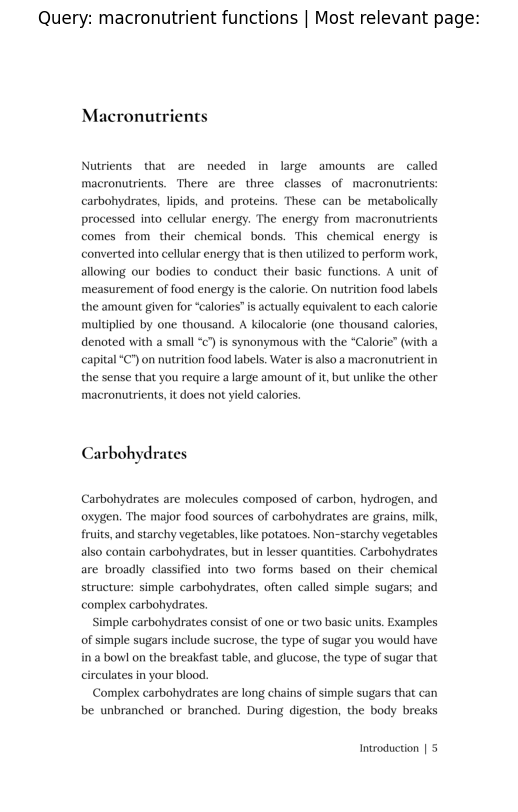

In [81]:
import fitz # pymupdf library


# open PDF and load target
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # Note: page numbers of our PDF start at 41+

# Get the image of the page
img = page.get_pixmap(dpi=300)


# save image (optional)
img.save("output_filenam.png")
doc.close()


# Convert the pixmap to numpy array
img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: {query} | Most relevant page:")
plt.axis("off")
plt.show()

### Similarity Measures: dot product and cosine similarity

Two of the most common similarity measures between vectors are dot product and cosine similarity.

In essence, closer vectors will have higher vectors, further away vectors will have lower scores.

Vectors have direction (which way is it going) an magnitud (how long is it)

In [48]:
embeddings[0].shape

torch.Size([768])

In [49]:
import torch

def dot_product(vector_1, vector_2):
    return torch.dot(vector_1, vector_2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example vectors/tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

print("\n")

# Cosine similarity: normalizes the magnitude, as we only care about direction
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)


Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [50]:
# Our mpnet model normalizes the vectors, so we don't have to do cosine similarity, dot product will do as the magnitude is already normalized
embedding_model.encode("yo yo yo")

array([-1.47896726e-02,  6.07223511e-02, -8.44547711e-03, -4.19229195e-02,
        1.72062544e-03, -3.49341799e-03, -5.70893884e-02, -1.28531754e-02,
       -4.02718335e-02,  1.02325901e-02,  1.35224080e-02,  3.08567081e-02,
       -1.32591007e-02, -8.32352880e-03, -4.17332090e-02, -3.12439874e-02,
        2.49716435e-02,  3.11922398e-04, -5.86870685e-02,  1.02444654e-02,
       -7.34617235e-03,  1.46217411e-02,  8.01337436e-02,  1.63536780e-02,
       -7.10161105e-02, -4.95852809e-03,  3.08478065e-02,  2.28216741e-02,
       -6.00186139e-02, -5.01742475e-02, -3.39074358e-02,  3.57718319e-02,
       -6.75585028e-03,  3.38734277e-02,  2.38579310e-06, -2.77584810e-02,
        1.31438309e-02,  3.50094959e-02, -1.39659233e-02,  1.71772484e-02,
       -6.81269094e-02,  1.27506349e-03,  3.58694866e-02, -2.65651569e-03,
       -1.67821553e-02, -2.95100585e-02,  1.31159062e-02, -2.77276011e-03,
        3.83434724e-03, -3.48792225e-02,  1.57431550e-02, -3.09773907e-02,
       -8.20843503e-02, -

### Functionizing our semantic search pipeline

Let's put all the steps above for semantic search into functions so we can repeat the workflow.

In [51]:
def retrieve_relevant_resources(query: str, 
                                embeddings: torch.tensor, 
                                model: SentenceTransformer=embedding_model, 
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get the dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")
    
    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str, 
                                embeddings: torch.tensor, 
                                pages_and_chunks: list[dict]=pages_and_chunks, 
                                n_resources_to_return: int=5):
    """Finds relevant passages given a query, and prints them out along with their scores"""
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings, n_resources_to_return=n_resources_to_return)

    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

In [52]:
query = "foods high in fiber"
retrieve_relevant_resources(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on 1679 embeddings: 0.00007 seconds.


(tensor([0.7061, 0.6810, 0.5566, 0.5344, 0.5187], device='cuda:0'),
 tensor([ 418,  360,  358, 1047,  412], device='cuda:0'))

In [53]:
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on 1679 embeddings: 0.00006 seconds.
Score: 0.7061
Text:
Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. •Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page Number: 276


Score: 0.6810
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in the large intestine so they can be broken down to a greater
extent than in

### Getting an LLM for local generation

We want to focus on local generation.

However, this process will work with an LLM API.

- [Open LLM Leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard)
- [The Bloke](https://huggingface.co/TheBloke)

What is a generative LLM?
- Goes from text input -> generate text output

Which LLM should I use?
- How much hardware VRAM do you have available

### Checking our local GPU memory availability

In [54]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30) )
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 16 GB


In [55]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sun Apr 21 21:25:23 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 44%   57C    P2    40W / 140W |   3173MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Note: 
* to use `gemma-7b-it` or other Gemma models, you have to accept terms and conditions on Hugging Face: https://huggingface.co/google/gemma-7b-it
* to download models and run locally from Hugging Face, you may need to sign in to the Hugging Face cli.

In [56]:
%pip install -U "huggingface_hub[cli]"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 12.9 MB/s eta 0:00:00


Note: you may need to restart the kernel to use updated packages.


`set_env.sh` looks like:
```shell
#!/bin/sh
git config --global credential.helper store
huggingface-cli login --token "<user-access-token-goes-here>" --add-to-git-credential
```

In [57]:
!sh set_env.sh
!huggingface-cli whoami

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Token is valid (permission: read).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


c3n7


In [58]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 16 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


### Loading an LLM locally

We can load an LLM locally using huggingface transformers.  
The model I'm going to use on the RTX A4000 - https://huggingface.co/google/gemma-2b-it

To get a model running locally we're going to need:
1. A quantization config (optional) - a config on what precision to load the model in (e.g. 8 it, 4bit, etc).
2. A model ID - this will tell transformers which model/tokenizer to load
3. A tokenizer - this turns text into numbers ready for the LLM (note: a tokenizer is different from an embedding model)
4. An LLM Model - this will be what we use to generate text based on an input.

> **Note:** There are many tips and tricks on loading/making LLMs work faster. One of the best ones is flash_attn (Flash Attention 2). See the upstream GitHub for more.  
> https://developer.nvidia.com/cuda-gpus

In [59]:
!pip install bitsandbytes transformers accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 19.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 20.6 MB/s eta 0:00:00


In [60]:
%pip install flash-attn --no-build-isolation

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 82.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 64.5 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.5.7-cp39-cp39-linux_x86_64.whl size=121972069 sha256=0b2af61cc7a693b2f9cff2962c6df6d3cee61a4b2ac6f1f1067fcbc385c09d95
  Stored in directory: /root/.cache/pip/wheels/3b/e4/72/268418d3d0a48c7349ccbb99e095a2ba2530524556a24f6403
Successfully built flash-attn
Note: you may need to restart the kernel to use updated packages.


In [61]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create a quantization config
# Note: requires !pip install bitsandbytes accelerate
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

# Bonus: flash_attention 2 = faster attention mechanism
# Flash Attention 2 requires a GPU with a compute score capability score of 8.0+ (Ampere, Ada Lovelace, Hopper and above)
# https://developer.nvidia.com/cuda-gpus
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # scaled dot product attention
print(f"[INFO] Using attention implementation: {attn_implementation}")


# 2. Pick a model we'd like to use
print(f"[INFO] we are using model {model_id}")
model_id = model_id

# 3. Instantiate tokenizer (turns text into tokens)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, 
                                                torch_dtype=torch.float16, 
                                                quantization_config=quantization_config if use_quantization_config else None,
                                                low_cpu_mem_usage=False, # Use as much memory as we can, without offloading to the cpu
                                                attn_implementation=attn_implementation)

if not use_quantization_config:
    print(f"[INFO] Moving model to cuda")
    llm_model.to("cuda")


[INFO] Using attention implementation: flash_attention_2
[INFO] we are using model google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

[INFO] Moving model to cuda


In [62]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sun Apr 21 21:26:23 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   47C    P2    38W / 140W |   7649MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [63]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaFlashAttention2(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): Gemm

In [64]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [65]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameter and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": model_mem_bytes, 
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012344832, 'model_mem_mb': 4780.14, 'model_mem_gb': 4.67}

We got the size of our model, this means to load the selected model, we need a minimum 4.67 GB of VRAM, however due to the calculations that take place, this one will baloon.

### Generating text with our LLM

Let's generate text with our local LLM!

* Note: Some models have been trained/tuned to generate text with a specific template in mind

Because `gemma-x-it` has been trained in an instruction-tuned manner, we should follow the instruction template for the best results.  
https://huggingface.co/google/gemma-2b-it#chat-template

For `mistral` it could be: https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2

In [66]:
input_text = "What are the macrunutrients, and what roles do they play in the human body?"
print(f"Input text: \n{input_text}")

# Create prompt template
dialogue_template = [
    {"role": "user",
    "content": input_text}
]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                        tokenize=False,
                                        add_generation_prompt=True)

print(f"\nPrompt (formatted):\n{prompt}")

Input text: 
What are the macrunutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macrunutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



In [67]:
tokenizer

GemmaTokenizerFast(name_or_path='google/gemma-2b-it', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	5: AddedToken("<2mass>", rstrip=False, lstrip=False, single_w

In [68]:
%%time

# Tokenize the input text (turn it into numbers and send it to the GPU)
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate outputs from local LLM
outputs = llm_model.generate(**input_ids, max_new_tokens=256)

print(f"Model output (tokens):\n{outputs[0]}\n")

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573,   7667,
          3153, 184592, 235269,    578,   1212,  16065,    749,    984,   1554,
           575,    573,   3515,   2971, 235336,    107,    108,    106,   2516,
           108,  21404, 235269,   1517, 235303, 235256,    476,  13367,    576,
           573,   3885, 186809, 184592,    578,   1024,  16065,    575,    573,
          3515,   2971, 235292,    109,    688,  12298,   1695, 184592,    688,
           708,  37132,    674,    573,   2971,   4026,    575,   2910,  15992,
           577,  10528,   1426,   2962, 235265,   2365,    708,  13538,   1280,
          1378,   1872,  14486, 235292, 186809, 184592,    578,  92800, 184592,
        235265,    109,    688,  12298,   1695, 184592,    688,    109, 235287,
          5231, 156615,  56227,  66058,  34428,   4134,    604,    573,   2971,
        235303, 235256,   5999,    578,  29703, 235265,   2365,    708,    573,
          2971, 2

In [69]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macrunutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
Sure, here's a summary of the major macronutrients and their roles in the human body:

**Macronutrients** are nutrients that the body needs in large amounts to maintain good health. They are divided into two main categories: macronutrients and micronutrients.

**Macronutrients**

* **Carbohydrates:** Provide energy for the body's cells and tissues. They are the body's main source of fuel.
* **Protein:** Is essential for building and repairing tissues, enzymes, and hormones. It also helps to regulate blood sugar levels.
* **Fat:** Provides energy, helps to absorb vitamins, and insulates the body.

**Micronutrients**

* **Calcium:** Involved in building bones and teeth, muscle contraction, and nerve function.
* **Iron:** Essential for red blood cell production.
* **Vitamin D:** Helps the body absorb calcium.
* **Vitamin B12:**

In [70]:

# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How can one balance exercise and dieting?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions 
query_list

['What are the macronutrients, and what roles do they play in the human body?',
 'How do vitamins and minerals differ in their roles and importance for health?',
 'Describe the process of digestion and absorption of nutrients in the human body.',
 'What role does fibre play in digestion? Name five fibre containing foods.',
 'Explain the concept of energy balance and its importance in weight management.',
 'How can one balance exercise and dieting?',
 'What are symptoms of pellagra?',
 'How does saliva help with digestion?',
 'What is the RDI for protein per day?',
 'water soluble vitamins']

In [71]:
import random
query = random.choice(query_list)
print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)
scores, indices

Query: What are the macronutrients, and what roles do they play in the human body?
[INFO] Time taken to get scores on 1679 embeddings: 0.00006 seconds.


(tensor([0.7302, 0.7233, 0.6942, 0.6828, 0.6416], device='cuda:0'),
 tensor([42, 47, 41, 46, 52], device='cuda:0'))

### Augmenting our prompt with context items

We've done retrieval.

We've done generation.

Time to augment!

The concept of augmenting a prompt with context items is also referred to as prompt engineering.

Prompt engineering is a field of active research and many new styles and techniques are being found out.

However, there are a few techniques that work quite well:
- https://www.promptingguide.ai/
- https://github.com/brexhq/prompt-engineering
- https://arxiv.org/abs/2401.14423
- https://www.anthropic.com/news/prompt-engineering-for-business-performance

We're going to use a couple of prompting techniques:
1. Give clear instructions.
2. Give a few examples of input/output (e.g given input x, give output y).
3. Give room to think (e.g "create a scratchpad" / "show your working space" / "let's think step by step...").

Let's create a function to format a prompt with context items.

In [72]:
def prompt_formatter(query: str, context_items: list[dict]) -> str:
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items]) 

#     base_prompt = """Based on the following context items, please answer the query.
# Context items:
# {context}
# Query: {query}
# Answer:"""

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt 
    dialogue_template = [
        {"role": "user", "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(dialogue_template, tokenize=False, add_generation_prompt=True)
    return prompt

query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

# Creae a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format our prompt
prompt = prompt_formatter(query=query, context_items=context_items)
print(prompt)

Query: How does saliva help with digestion?
[INFO] Time taken to get scores on 1679 embeddings: 0.00005 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and b

Prompt example:
Based on the on the following contexts:
- asfsadfas
- awerjkl
- asdfajsldf
- rqwierqpwe
- asadkaew

Please answer the following query: What are the macronutrients and what do the do?  
Answer:


In [73]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
# https://www.promptingguide.ai/introduction/settings
outputs = llm_model.generate(
    **input_ids,
    temperature=0.7, # from 0 to 1 in most cases, and the lower the value, the more deterministic the text, the higher the more the more creative
    do_sample=True, # Whether or not to use sampling - https://huyenchip.com/2024/01/16/sampling.html
    max_new_tokens=256)

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG Answer:\m{output_text.replace(prompt, '')}")

Query: How does saliva help with digestion?
RAG Answer:\m<bos>The passage does not specify how saliva helps with digestion, so I cannot answer this question from the provided context.<eos>
CPU times: user 504 ms, sys: 76 ms, total: 580 ms
Wall time: 578 ms


### Functionize our LLM answering feature

Wouldn't it be cool if our RAG pipeline worked from a single function?

E.g you input a query and you get a generated answer + optionally get the source documents (the context) where that answer was generated from.

Let's make a function to do it!

In [74]:
def ask(query: str, 
        temperature: float=0.7,
        max_new_tokens: int=256,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # RETRIEVAL
    # Get the scores and indices of top results
    scores, indices = retrieve_relevant_resources(query=query,
                                                    embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add scores to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    
    # AUGMENTATION
    # Create the prompt and format it with context items
    prompt = prompt_formatter(query=query, context_items=context_items)

    # GENERATION
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                temperature=temperature,
                                do_sample=True,
                                max_new_tokens=max_new_tokens)

    # Decode the tokens into text
    output_text = tokenizer.decode(outputs[0])

    # Format the answer
    if format_answer_text:
        # Replace prompt and special tokens
        output_text = output_text.replace(prompt, '').replace("<bos>", "").replace("<eos>", "")

    
    # Only return the answer without context items
    if return_answer_only:
        return output_text
    

    return output_text, context_items

In [85]:
from IPython.display import display, Markdown

# query = random.choice(query_list)
query = "how can one avoid malnutrition"
print(f"Query: {query}")
output = ask(query=query, return_answer_only=False)

# print(output[0])
# output[1]
display(Markdown(output[0]))

Query: how can one avoid malnutrition
[INFO] Time taken to get scores on 1679 embeddings: 0.00006 seconds.


The passage emphasizes that malnutrition is characterized by a lack of proper nutrition and does not distinguish between the consequences of too many nutrients or the lack of nutrients. Therefore, one way to avoid malnutrition is to make sure that children and adults are eating a balanced diet that includes a variety of nutrients, including protein, vitamins, and minerals.

## Summary
* RAG = powerful technique for generating text based on reference documents
* Hardware use = use GPU where possible to accelerate embedding creation and LLM generation
    * Keep in mind the limitations on your local Hardware
* Many open-source embedding models and LLMs starting to become available, keep experimenting to find whichs is best.


## Extensions
- May want to improve text extraction with something like Marker - https://github.com/VikParuchuri/marker
- Guide to more advanced PDF extraction - https://towardsdatascience.com/extracting-text-from-pdf-files-with-python-a-comprehensive-guide-9fc4003d517
- See the following prompt engineering resources for more prompting techniques - promptinguide.ai, Brex's Prompt Engineering Guide
- What happens when a query comes through that there isn't any context in the textbook on?
- Try another embedding model (e.g. Mixed Bread AI large, mixedbread-ai/mxbai-embed-large-v1, see: https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)
- Try another LLM... (e.g. Mistral-Instruct)
- Try different prompts (e.g. see prompting techniques online)
- Our example only focuses on text from a PDF, however, we could extend it to include figures and images
- Evaluate the answers -> could use another LLM to rate our answers (e.g. use GPT-4 to make)
- Vector database/index for larger setup (e.g. 100,000+ chunks)
- Libraries/frameworks such as LangChain / LlamaIndex can help do many of the steps for you - so it's worth looking into those next, wanted to recreate a workflow with lower-level tools to show the principles
- Optimizations for speed
- See Hugging Face docs for recommended speed ups on GPU - https://huggingface.co/docs/transformers/perf_infer_gpu_one
- Optimum NVIDIA - https://huggingface.co/blog/optimum-nvidia, GitHub: https://github.com/huggingface/optimum-nvidia
- See NVIDIA TensorRT-LLM - https://github.com/NVIDIA/TensorRT-LLM
- See GPT-Fast for PyTorch-based optimizations - https://github.com/pytorch-labs/gpt-fast
- Flash attention 2 (requires Ampere GPUs or newer) - https://github.com/Dao-AILab/flash-attention
- Stream text output so it looks prettier (e.g. each token appears as it gets output from the model)
- Turn the workflow into an app, see Gradio type chatbots for this - https://www.gradio.app/guides/creating-a-chatbot-fast, see local example: https://www.gradio.app/guides/creating-a-chatbot-fast#example-using-a-local-open-source-llm-with-hugging-face
- Few shot prompting for Gemma 7b: https://www.kaggle.com/code/vbookshelf/kagglebot-gemma-7b-it-rag-w-few-shot-prompting